In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
import re
import os
import glob
from matplotlib import rcParams
from sklearn import linear_model
from sklearn import metrics
%matplotlib inline

In [29]:
rcParams['figure.figsize'] = 10,10
rcParams['axes.linewidth'] = 4.0
rcParams['savefig.dpi'] = 500
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [30]:
def rmse(pred, tar):
    return np.sqrt(((pred - tar) ** 2).mean())

def convertAffinity(x):
    return 8.314*300/1000/4.184*np.log(x/1000000)

In [32]:
#Conf 1
tmp=[]
df=[]
#os.chdir("/mnt/u1/pde2/glide-pde-conf1/old_vsw_1")
os.chdir("/home/chuck/u1/pde2/glide-pde-conf1/vsw_sp")
all_filenames=[i for i in glob.glob('vsw_sp*.{}'.format("csv"))]
for f in all_filenames:
    tmp=pd.read_csv(f, header=0, sep=',', engine='python')
    tmp.sort_values(by=['r_i_docking_score'], inplace=True)
    tmp.drop_duplicates(['title'], inplace=True)
    df.append(tmp)
dF1=pd.concat(df, axis=0, ignore_index=True)
dF1.drop(dF1.columns.difference(['title','r_i_docking_score']), 1, inplace=True)
dF1.rename(columns={'r_i_docking_score': 'Conf 1'}, inplace=True)

In [33]:
#Conf 2
tmp=[]
df=[]
#os.chdir("/mnt/u1/pde2/glide-pde-conf2/vsw_1")
os.chdir("/home/chuck/u1/pde2/glide-pde-conf2/vsw_sp")
all_filenames=[i for i in glob.glob('vsw_sp*.{}'.format("csv"))]
for f in all_filenames:
    tmp=pd.read_csv(f, header=0, sep=',', engine='python')
    tmp.sort_values(by=['r_i_docking_score'], inplace=True)
    tmp.drop_duplicates(['title'], inplace=True)
    df.append(tmp)
dF2=pd.concat(df, axis=0, ignore_index=True)
dF2.drop(dF2.columns.difference(['title','r_i_docking_score']), 1, inplace=True)
dF2.rename(columns={'r_i_docking_score': 'Conf 2'}, inplace=True)

In [34]:
combined=pd.merge(dF1, dF2, how='outer', on='title')
combined['Lowest'] = combined[['Conf 1','Conf 2']].min(axis=1)
combined.sort_values(by=['Lowest'], inplace=True)
combined["Rank"] = combined['Lowest'].rank(method='first')
combined.sort_values(['title'], inplace=True)

In [35]:
all=pd.read_csv("/home/chuck/ipn/PDE2/all.csv", header=0, sep=',', engine='python')
fin1=pd.merge(combined, all, how='outer', on='title')
fin1.to_csv( "/home/chuck/ipn/PDE2/DOCK_SP-scores.csv", index=False)

## Test 

In [36]:
fin1['Exp dG'] = fin1['IC50'].apply(convertAffinity)

In [37]:
#fin1["Lowest"] = pd.to_numeric(fin1["Lowest"])
X = sm.add_constant(fin1["Lowest"])
Y = fin1["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)
b = regr.intercept_
m = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

                            OLS Regression Results                            
Dep. Variable:                 Exp dG   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.384
Date:                Tue, 03 May 2022   Prob (F-statistic):              0.242
Time:                        18:48:28   Log-Likelihood:                -270.19
No. Observations:                 140   AIC:                             544.4
Df Residuals:                     138   BIC:                             550.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6118      0.931     -4.956      0.0

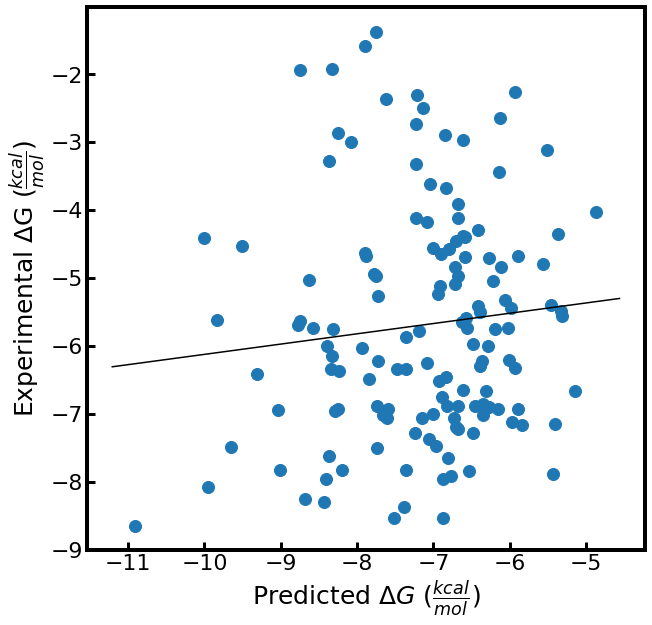

In [38]:
X=fin1["Lowest"]
Y=fin1["Exp dG"]

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0')
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='k')
plt.xlabel(r'Predicted $\Delta G \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tick_params(which='both',direction='in',length=8, width=3,)
# Save figure
#plt.savefig(graph_filepath, dpi=300, format='png', bbox_inches='tight')
plt.savefig("/home/chuck/ipn/figs/corr-sp.png", format='png', transparent=True, bbox_inches='tight')

#rmse_val = rmse(X, Y)
#print("RMSD is: " + str(rmse_val))